# Gong et al example (alternative loss)

In [1]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib as mpl
import torch.optim as optim
from torchdiffeq import odeint
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as ticker
from matplotlib import rcParams

# customized settings
params = {  # 'backend': 'ps',
    'font.family': 'serif',
    'font.serif': 'Latin Modern Roman',
    'font.size': 7,
    'axes.labelsize': 'medium',
    'axes.titlesize': 'medium',
    'legend.fontsize': 'medium',
    'xtick.labelsize': 'small',
    'ytick.labelsize': 'small',
    'savefig.dpi': 150,
    'text.usetex': True, 
    'legend.title_fontsize': 4}
# tell matplotlib about your params
rcParams.update(params)

# set nice figure sizes
fig_width_pt = 433.62 # Get this from LaTeX using \showthe\columnwidth
golden_mean = (np.sqrt(5.) - 1.) / 2.  # Aesthetic ratio
ratio = golden_mean
inches_per_pt = 1. / 72.27  # Convert pt to inches
fig_width = fig_width_pt * inches_per_pt  # width in inches
fig_height = fig_width*ratio  # height in inches
fig_size = [fig_width,fig_height]
rcParams.update({'figure.figsize': fig_size})

Define time horizon, initial condition, and target state.

In [6]:
T = 1
true_x0 = torch.tensor([0.,1.])
t = torch.linspace(0., T, 1000)
target_x = torch.tensor([1.,1.])
B = torch.tensor([0.0,1.0])

Define neural ODE with control term.

In [26]:
class ODE_func(nn.Module):

    def __init__(self, number_layers, number_neurons, output_control = False):
        super(ODE_func, self).__init__()

        self.input = nn.Linear(1,number_neurons)
        self.linears = nn.ModuleList([nn.Linear(number_neurons, number_neurons) for i in range(number_layers)])
        self.output = nn.Linear(number_neurons,1)
        self.number_layers = number_layers
        
        self.output_control = output_control
        
    def forward(self, t, y):
        u = self.input(torch.tensor([t]))
        
        for i in range(self.number_layers):
            u = nn.functional.elu(u)
            u = self.linears[i](u)
        u = nn.functional.elu(u)
        u = self.output(u)
        
        if self.output_control == False:
            return torch.tensor([y[1],-y[1]])+B*u
        else:
            return u

def weights_init(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.constant_(m.weight,val=1e-2)#kaiming_uniform_(m.weight)#constant_(m.weight,val=1e-2)
        torch.nn.init.constant_(m.bias,val=1e-2)

In [10]:
def mse(x,y):
    return np.linalg.norm(x-y)**2

Solve control problem.

In [27]:
net_params = []
best_loss_arr = []
u_mse = []
eta = 0.5e-2

number_layers = [2,4,8,16,32,64]

for number_layer in number_layers:
    func = ODE_func(1, 6*number_layer)
    func.apply(weights_init)

    optimizer = optim.Adam(func.parameters(), lr=eta)

    best_model = func
    loss_new = 1e9

    for itr in range(1, 100):

        optimizer.zero_grad()
        pred_x = odeint(func, true_x0, t, method='dopri5')
        loss = ((pred_x[-1] - target_x)**2).sum()
        loss.backward()
        optimizer.step()

        if loss < loss_new:
            best_model = func
            loss_new = loss
        
        if itr % 10 == 0:
            print(itr, loss)
            
        itr += 1
    
    func = best_model
    func.output_control = True
    u_mse.append(mse(np.array([float(func(x,torch.tensor([0.,0.]))) for x in t]),np.ones(len(t))))
    net_params.append(best_model)
    best_loss_arr.append(loss_new)

10 tensor(0.4102, grad_fn=<SumBackward0>)
20 tensor(0.1283, grad_fn=<SumBackward0>)
30 tensor(0.0304, grad_fn=<SumBackward0>)
40 tensor(0.0013, grad_fn=<SumBackward0>)
50 tensor(0.0090, grad_fn=<SumBackward0>)
60 tensor(0.0013, grad_fn=<SumBackward0>)
70 tensor(0.0009, grad_fn=<SumBackward0>)
80 tensor(0.0015, grad_fn=<SumBackward0>)
90 tensor(0.0007, grad_fn=<SumBackward0>)
10 tensor(0.2926, grad_fn=<SumBackward0>)
20 tensor(0.0416, grad_fn=<SumBackward0>)
30 tensor(0.0090, grad_fn=<SumBackward0>)
40 tensor(0.0053, grad_fn=<SumBackward0>)
50 tensor(0.0023, grad_fn=<SumBackward0>)
60 tensor(0.0036, grad_fn=<SumBackward0>)
70 tensor(0.0009, grad_fn=<SumBackward0>)
80 tensor(0.0015, grad_fn=<SumBackward0>)
90 tensor(0.0009, grad_fn=<SumBackward0>)
10 tensor(0.0362, grad_fn=<SumBackward0>)
20 tensor(0.0062, grad_fn=<SumBackward0>)
30 tensor(0.0047, grad_fn=<SumBackward0>)
40 tensor(0.0010, grad_fn=<SumBackward0>)
50 tensor(0.0018, grad_fn=<SumBackward0>)
60 tensor(0.0013, grad_fn=<SumBack

In [67]:
func = ODE_func(number_layer, 6)
func = net_params[0]
func.output_control = False
pred_x = odeint(func, true_x0, t, method='dopri5')

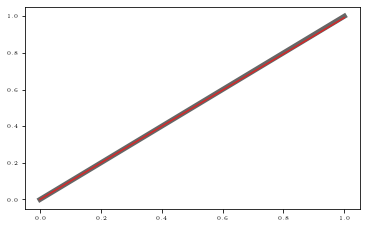

In [68]:
plt.figure()
plt.plot(t,t,label='OC',color='k',alpha=0.6,linewidth=5)
plt.plot(t,[pred_x[i][0] for i in range(len(pred_x))],label='NN',color="tab:red")
plt.show()

In [69]:
func.output_control = True

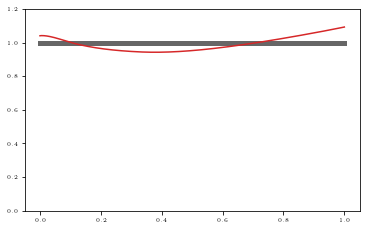

In [71]:
plt.figure()
plt.plot(t,np.ones_like(t),label='OC',color='k',alpha=0.6,linewidth=5)
plt.plot(t,[func(x,torch.tensor([0.,0.])) for x in t],label='NN',color="tab:red")
plt.ylim(0,1.2)
plt.show()

In [12]:
best_loss_arr_elu = best_loss_arr
u_mse_elu = u_mse
net_params_elu = net_params

In [28]:
best_loss_arr_elu_one_layer = best_loss_arr
u_mse_elu_one_layer = u_mse
net_params_elu_one_layer = net_params

In [24]:
best_loss_arr_relu_one_layer = best_loss_arr
u_mse_relu_one_layer = u_mse
net_params_relu_one_layer = net_params

In [19]:
best_loss_arr_relu = best_loss_arr
u_mse_relu = u_mse
net_params_relu = net_params

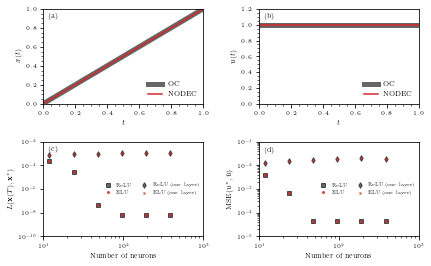

In [29]:
fig, ax =plt.subplots(ncols=2,nrows=2)
fig.patch.set_facecolor('white')

func = net_params_elu[2]
func.output_control = False
pred_x = odeint(func, true_x0, t, method='dopri5')

ax[0,0].text(0.03,0.9,r"(a)")
ax[0,0].plot(t,t,label='OC',color='k',alpha=0.6,linewidth=5)
ax[0,0].plot(t,[pred_x[i][0] for i in range(len(pred_x))],label='NODEC',color="tab:red")
ax[0,0].set_xlabel(r"$t$")
ax[0,0].set_ylabel(r"$x(t)$")
ax[0,0].set_xlim(0,1)
ax[0,0].set_ylim(0,1)
ax[0,0].xaxis.set_minor_locator(ticker.MultipleLocator(0.05))
ax[0,0].yaxis.set_minor_locator(ticker.MultipleLocator(0.05))
ax[0,0].legend(loc=4,frameon=False)

func.output_control = True
ax[0,1].text(0.03,0.9*1.2,r"(b)")
ax[0,1].plot(t,np.ones_like(t),label='OC',color='k',alpha=0.6,linewidth=5)
ax[0,1].plot(t,[func(x,torch.tensor([0.,0.])) for x in t],label='NODEC',color="tab:red")
ax[0,1].set_ylim(0,1.2)
ax[0,1].set_xlabel(r"$t$")
ax[0,1].set_ylabel(r"$u(t)$")
ax[0,1].set_xlim(0,1)
ax[0,1].set_ylim(0,1.2)
ax[0,1].xaxis.set_minor_locator(ticker.MultipleLocator(0.05))
ax[0,1].yaxis.set_minor_locator(ticker.MultipleLocator(0.05))
ax[0,1].legend(loc=4,frameon=False)

ax[1,0].text(11.6,0.15*1e-2,r"(c)")
ax[1,0].plot([x*6 for x in number_layers],best_loss_arr_relu,'s',color='k',alpha=0.6,markersize=4,label="ReLU")
ax[1,0].plot([x*6 for x in number_layers],best_loss_arr_elu,'o',color='tab:red',alpha=0.8,markersize=2,label="ELU")
ax[1,0].plot([x*6 for x in number_layers],best_loss_arr_relu_one_layer,'d',color='k',alpha=0.6,markersize=4,label="ReLU (one layer)")
ax[1,0].plot([x*6 for x in number_layers],best_loss_arr_elu_one_layer,'x',color='tab:red',alpha=0.8,markersize=2,label="ELU (one layer)")
ax[1,0].set_xlim(1e1,1e3)
ax[1,0].set_ylim(1e-10,1e-2)
ax[1,0].legend(loc=5,frameon=False,fontsize=4.5,ncol=2)
ax[1,0].set_xscale('log')
ax[1,0].set_yscale('log')
ax[1,0].set_xlabel(r"Number of neurons")
ax[1,0].set_ylabel(r"$L(\mathbf{x}(T),\mathbf{x}^*)$")

ax[1,1].text(11.6,0.35*1e-1,r"(d)")
ax[1,1].plot([x*6 for x in number_layers],np.array(u_mse_relu)/len(t),'s',color='k',alpha=0.6,markersize=4,label="ReLU")
ax[1,1].plot([x*6 for x in number_layers],np.array(u_mse_elu)/len(t),'o',color='tab:red',alpha=0.8,markersize=2,label="ELU")
ax[1,1].plot([x*6 for x in number_layers],np.array(u_mse_relu_one_layer)/len(t),'d',color='k',alpha=0.6,markersize=4,label="ReLU (one layer)")
ax[1,1].plot([x*6 for x in number_layers],np.array(u_mse_elu_one_layer)/len(t),'x',color='tab:red',alpha=0.8,markersize=2,label="ELU (one layer)")
ax[1,1].set_xlim(1e1,1e3)
ax[1,1].set_ylim(1e-5,1e-1)
ax[1,1].legend(loc=5,frameon=False,fontsize=4.5,ncol=2)
ax[1,1].set_xscale('log')
ax[1,1].set_yscale('log')
ax[1,1].set_xlabel(r"Number of neurons")
ax[1,1].set_ylabel(r"$\mathrm{MSE}(u^*,\hat{u})$")

plt.tight_layout()
plt.subplots_adjust(wspace=0.35,hspace=0.4)
plt.savefig("ann_moving_particle.png",dpi=300)
plt.show()

In [282]:
my_data = []
nn = 5
for i in range(number_layers[nn]):
    my_data.append(list(net_params_relu[nn].linears[i].weight.data.numpy().flatten()))

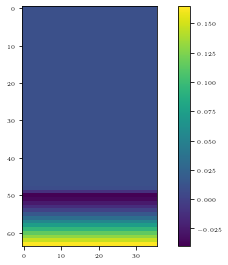

In [283]:
plt.figure()
plt.imshow(my_data)
plt.colorbar()
#plt.ylim(0,2.5)
#plt.yticks([0,2.5])
plt.tight_layout()
plt.show()

In [338]:
np.linalg.norm(np.array([1,1,1]))

1.7320508075688772

In [339]:
np.sqrt(3)

1.7320508075688772